In [34]:
import yfinance as yf
import pandas as pd

# 株価データを取得する銘柄のシンボル
ticker_symbol = "^N225"  

# 2024年7月1日から2024年9月18日までの株価データを取得
stock_data = yf.download(ticker_symbol, start="2024-04-01", end="2024-06-01")

# 取得したデータをエクセルファイルに保存
excel_file = "japan_data_09.xlsx"
stock_data.to_excel(excel_file)

print(f"エクセルファイルに保存しました: {excel_file}")

# エクセルファイルを読み込み
data = pd.read_excel(excel_file)

# 読み込んだデータをCSVファイルに変換して保存
csv_file = "japan_data_09.csv"
data.to_csv(csv_file, index=False)

print(f"CSVファイルに変換して保存しました: {csv_file}")

# CSVファイルを読み込む
df = pd.read_csv(csv_file)

# データの先頭5行を表示して確認する
print("CSVファイルのデータの先頭5行:")
print(df.head())


[*********************100%%**********************]  1 of 1 completed
エクセルファイルに保存しました: japan_data_09.xlsx
CSVファイルに変換して保存しました: japan_data_09.csv
CSVファイルのデータの先頭5行:
         Date          Open          High           Low         Close  \
0  2024-04-01  40646.699219  40697.218750  39706.449219  39803.089844   
1  2024-04-02  39892.589844  40151.050781  39707.871094  39838.910156   
2  2024-04-03  39503.718750  39625.898438  39217.039062  39451.851562   
3  2024-04-04  39928.328125  40243.019531  39773.140625  39773.140625   
4  2024-04-05  39237.390625  39274.761719  38774.238281  38992.078125   

      Adj Close     Volume  
0  39803.089844  134500000  
1  39838.910156  115800000  
2  39451.851562  123200000  
3  39773.140625  145100000  
4  38992.078125  129600000  


In [35]:
# 欠損値の確認
missing_values = data.isnull().sum()
print("欠損値の数:\n", missing_values)

# 欠損値のある行を削除
data = data.dropna()


欠損値の数:
 Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


In [36]:
import numpy as np

# 四本値の範囲を確認（負の値や極端に高い値を検出）
for column in ['Open', 'High', 'Low', 'Close']:
    print(f'{column} の異常値:', data[(data[column] < 0) | (data[column] > data[column].mean() + 3 * data[column].std())])

# 異常値を補正（例: 負の値を0に置き換える）
for column in ['Open', 'High', 'Low', 'Close']:
    data[column] = np.where(data[column] < 0, 0, data[column])


Open の異常値: Empty DataFrame
Columns: [Date, Open, High, Low, Close, Adj Close, Volume]
Index: []
High の異常値: Empty DataFrame
Columns: [Date, Open, High, Low, Close, Adj Close, Volume]
Index: []
Low の異常値: Empty DataFrame
Columns: [Date, Open, High, Low, Close, Adj Close, Volume]
Index: []
Close の異常値: Empty DataFrame
Columns: [Date, Open, High, Low, Close, Adj Close, Volume]
Index: []


In [37]:
from sklearn.preprocessing import StandardScaler

# 必要な列のみを選択して標準化
scaler = StandardScaler()
data[['Open', 'High', 'Low', 'Close', 'Volume']] = scaler.fit_transform(data[['Open', 'High', 'Low', 'Close', 'Volume']])


In [38]:
# 日付列を日付型に変換
data['Date'] = pd.to_datetime(data['Date'])

# 移動平均の計算（例: 20日移動平均）
# 〇〇日間の、上昇と下降トレンドを把握する。
data['Moving_Avg_20'] = data['Close'].rolling(window=20).mean()

# ボラティリティの計算（例: 標準偏差の20日移動平均）
# 価格変動の大きさ、不確実性、リスク評価。
data['Volatility_20'] = data['Close'].rolling(window=20).std()

# 欠損値の発生する先頭行を削除
data = data.dropna()

# 特徴量を含むデータの先頭5行を表示して確認
print("\n特徴量を追加したデータの先頭5行:")
print(data.head())


特徴量を追加したデータの先頭5行:
         Date      Open      High       Low     Close     Adj Close    Volume  \
19 2024-04-26 -1.365727 -1.168031 -1.243381 -1.062516  37934.761719  0.096154   
20 2024-04-30 -0.526074 -0.421362 -0.354574 -0.367091  38405.660156  1.270900   
21 2024-05-01 -0.819686 -0.677009 -0.559910 -0.561452  38274.050781 -0.630859   
22 2024-05-02 -0.967531 -0.790681 -0.669773 -0.617542  38236.070312 -0.923437   
23 2024-05-07 -0.063275 -0.048536  0.151984  0.267109  38835.101562 -0.333847   

    Moving_Avg_20  Volatility_20  
19       0.167657       1.373300  
20       0.064470       1.329193  
21      -0.051079       1.274314  
22      -0.140853       1.246107  
23      -0.210118       1.177812  


In [39]:
# 終値の1日後の値を追加
data['Next_Close'] = data['Close'].shift(-1)

# 終値が上がるか下がるかのラベルを作成
#　Tureなら1、Falseなら0
data['Price_Up'] = (data['Next_Close'] > data['Close']).astype(int)

# 最後の行は次の値がないため削除
data = data.dropna()

print(data[['Date', 'Close', 'Next_Close', 'Price_Up']].head())


         Date     Close  Next_Close  Price_Up
19 2024-04-26 -1.062516   -0.367091         1
20 2024-04-30 -0.367091   -0.561452         0
21 2024-05-01 -0.561452   -0.617542         0
22 2024-05-02 -0.617542    0.267109         1
23 2024-05-07  0.267109   -0.667309         0


In [40]:
#ランダムフォレストの分類器
#データ分割のためのライブラリ
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# 特徴量と目標変数を定義
features = ['Open', 'High', 'Low', 'Volume', 'Moving_Avg_20', 'Volatility_20']
target = 'Price_Up'

X = data[features]  # 特徴量データ
y = data[target]  # 目標変数データ

# データをトレーニングセットとテストセットに分割
#　データの80%をトレーニングセット、20%をテストセット、データのシャッフルを行わない。
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# ランダムフォレストモデルの構築
# 分類器で、100本の決定木
# モデルをトレーニングデータで学習
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

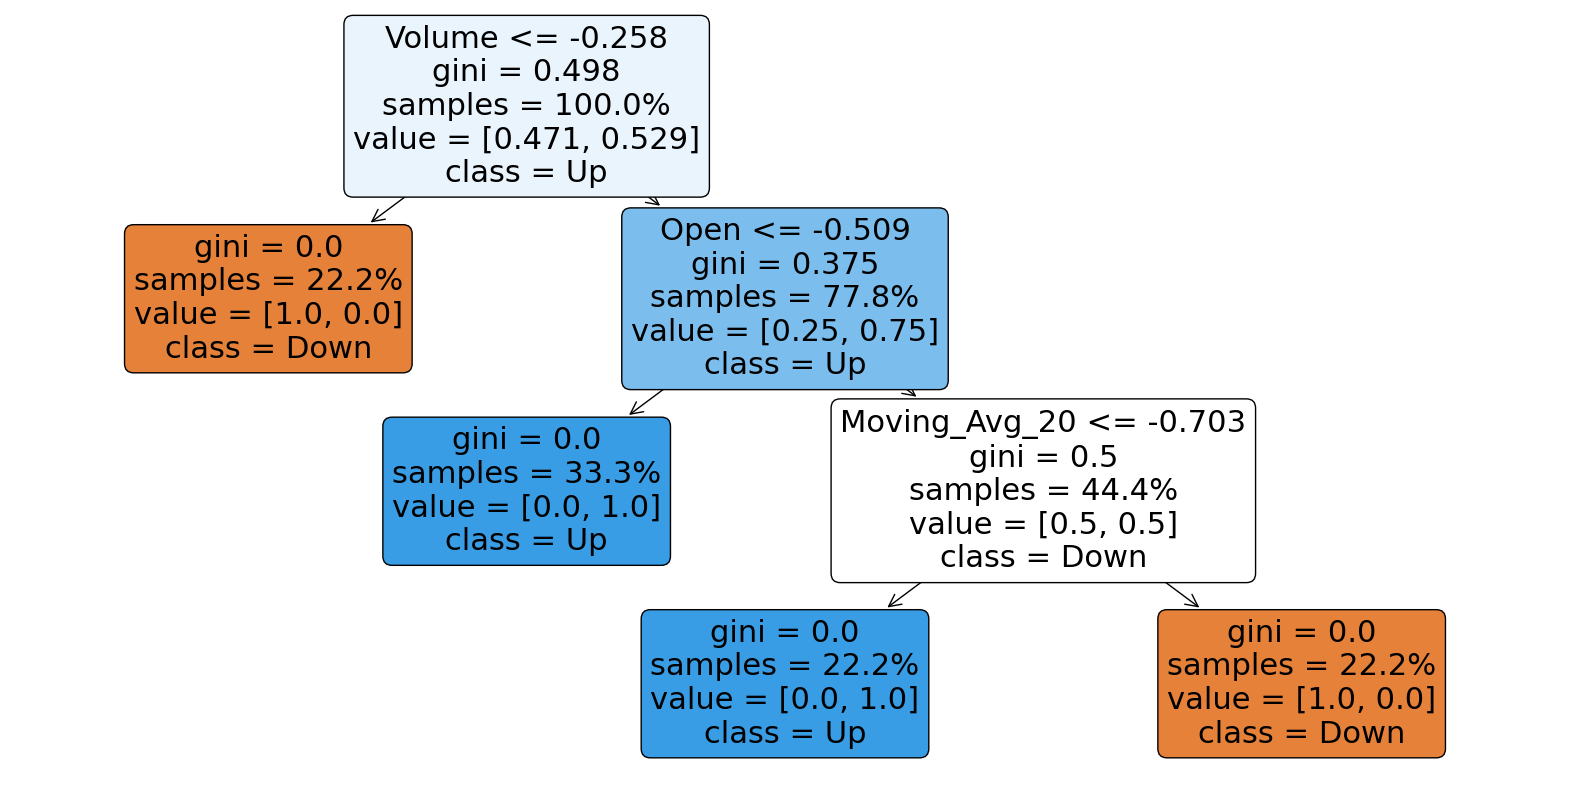

In [41]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# 決定木の可視化
plt.figure(figsize=(20, 10))
#100本あるうちの最初の1本を抽出
plot_tree(model.estimators_[0], 
          feature_names=features, 
          class_names=['Down', 'Up'], 
          filled=True, 
          rounded=True, 
          proportion=True)
plt.show()


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

# テストデータで予測
y_pred = model.predict(X_test)

# 正解率 (Accuracy)予測の正確さ
#20％のデータが正しく予測されているのか。
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

# 精度 (Precision)
#陽性と予測されたものの中で、どれだけ正確に陽性を予測できたかを示す。
precision = precision_score(y_test, y_pred)
print(f'Precision: {precision:.2f}')

#　再現率 (Recall)
#実際の陽性の中で、どれだけを正しく予測できたかを示す。
recall = recall_score(y_test, y_pred)
print(f'Recall: {recall:.2f}')


In [ ]:
import seaborn as sns

# 特徴量の重要度を抽出
feature_importances = model.feature_importances_
features_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})

# 特徴量の重要度を可視化
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=features_df.sort_values(by='Importance', ascending=False))
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.show()


In [ ]:
# X月X日以降データを予測
future_dates = pd.date_range(start='2024-09-23', end='2024-09-25')
future_predictions = []

for date in future_dates:
    # 特徴量データを準備
    latest_data = data.iloc[-1][features].values.reshape(1, -1)
    prediction = model.predict(latest_data)[0]
    future_predictions.append((date, prediction))
    
# 予測結果を表示
for date, prediction in future_predictions:
    print(f'Date: {date}, Prediction (Up=1, Down=0): {prediction}')


In [ ]:
# 勝率 (Hit Rate) ＝ 正解率
hit_rate = accuracy_score(y_test, y_pred)
print(f'Hit Rate (勝率): {hit_rate:.2f}')
